In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
dfpgr = pd.read_csv('Played_games_rounds_new.csv')
dfpgr_new = pd.read_csv('Played_games_next_month_new.csv')
dfgames = pd.read_csv('Gameid_info_new.csv')
dfcasino = pd.read_csv('Casino_tag_info_new.csv')

In [2]:
def weighted_jaccard_similarity(set1, set2, weights):
    intersection = set1.intersection(set2)
    weighted_intersection = sum(weights.get(feature, 0) for feature in intersection)
    union = set1.union(set2)
    weighted_union = sum(weights.get(feature, 0) for feature in union)
    return weighted_intersection / weighted_union if weighted_union != 0 else 0

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    similarity = intersection / union
    return similarity
def intersection_card(set1, set2):
    return len(set1.intersection(set2))
def feature_to_int(feature):
    return int(feature[8:])

In [3]:
class player:
    def __init__(self, playerid):
        self.playerid = playerid
        self.played_games = [x for x in dfpgr.loc[dfpgr.playerid == playerid].gameid]
        self.times = [x for x in dfpgr.loc[dfpgr.playerid == playerid].rounds]
        self.total = np.sum(self.times)
        self.played_games_times = dict(zip(self.played_games, self.times))
        self.feature_total_played_times = dict(zip(list(dfcasino['name'].unique()),[0]*120))
        self.category_total_played_times = dict(zip(list(dfgames['category'].unique()),[0]*10))
        self.provider_total_played_times = dict(zip(list(dfgames['provider'].unique()),[0]*14))
        self.features_played = []
        self.categories_played = set([])
        self.providers_played = set([])
        for gid in self.played_games:
            g = game(gid)
            for feature in g.features:
                self.feature_total_played_times[feature] += self.played_games_times[gid]
                if (not feature_to_int(feature) in self.features_played):
                    self.features_played.append(feature_to_int(feature)) 
            for provider in g.provider:
                self.providers_played.add(provider)
                self.provider_total_played_times[provider] += self.played_games_times[gid]
            for category in g.category:
                self.categories_played.add(category)
                self.category_total_played_times[category] += self.played_games_times[gid]
        self.feature_plays = dict([(feature_to_int(x),y) for x,y in self.feature_total_played_times.items()])
        self.feature_share = dict([(x,y/self.total) for x,y in self.feature_plays.items() if self.total != 0])

In [4]:
class game:
    def __init__(self, gameid):
        self.gameid = gameid
        self.times_played = 0
        self.exists = (gameid in list(dfpgr.gameid)) or (gameid in list(dfgames.gameid)) or (gameid in list(dfcasino.game_internal_id))
        self.features = [x for x in dfcasino.loc[dfcasino.game_internal_id == gameid].name]
        self.featuresN = [feature_to_int(x) for x in self.features]
        self.category = [x for x in dfgames.loc[dfgames.gameid == gameid].category]
        self.provider = [x for x in dfgames.loc[dfgames.gameid == gameid].provider]

In [5]:
games = [None]*3000
for i in range(0, 3000):
    games[i]= game(i)

whales = [387,867,761,561,563,461]
players = [None]*1201
for i in range(1,1201):
    if(i in whales):
        continue
    players[i] = player(i)
    for g in players[i].played_games:
        games[g].times_played += players[i].played_games_times[g]

plays = [0] * 3000
fplays = [0] * 130
players_plays = np.array([x.total for x in players if x != None])
    
for g in games:
    plays[g.gameid] += g.times_played
    for f in g.featuresN:
        fplays[f] += g.times_played

mean: 455.84170854271355
median: 90.0


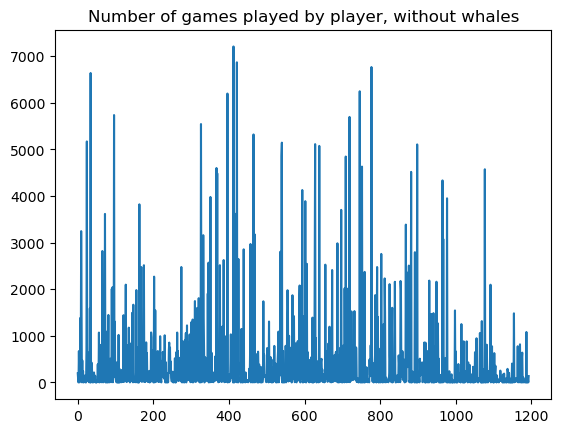

In [6]:
#print(sorted(players_plays,reverse=True))
plt.title("Number of games played by player, without whales")
plt.plot(players_plays)
print("mean: " + str(np.mean(players_plays)))
print("median: " + str(np.median(players_plays)))
#whales = [387,867,761,561,461]

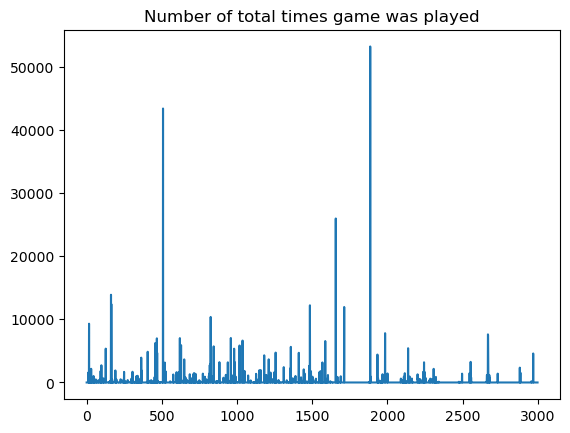

In [7]:
plt.title("Number of total times game was played")
plt.plot(plays)
most_popular = [1886,508,1657,162,164,1485,1713]
#1886,508,1657, >>  162,164,1485,1713

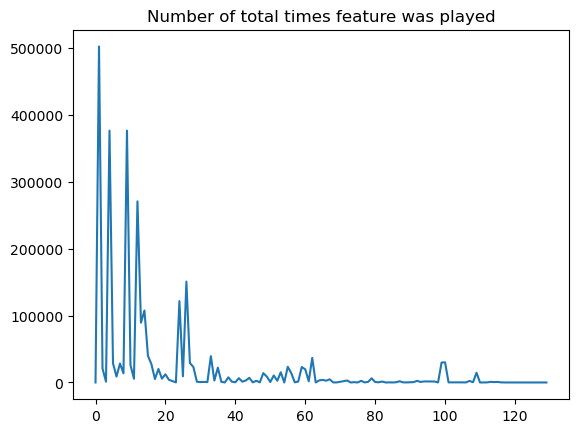

In [8]:
plt.title("Number of total times feature was played")
plt.plot(fplays)

In [9]:
#feature_times_played_if_i_played = np.zeros((120,120)) #ako je i odigran, koliko puta je odigran j
#feature_times_played_if_i_played_exclusive_j = np.zeros((120,120))# ako je i odigran, koliko puta je odigrana igra koja ima j, ali da nije u igri koja ima i i j
#feature_ratio_if_i_played_all_games = np.zeros((120,120)) #od igraca koji su igrali i, koliki je omjer igranih j i svih njihovih igara
#feature_ratio_if_i_played_only_i_games = np.zeros((120,120)) #od igraca koji su igrali i, koliki je omjer igranih j i igranih i igara
feature_ratio_if_i_played_exclusive_j = np.zeros((120,120))# od igraca koji su igrali i, koliki je omjer igranih j ALI bez igara koji imaju i i j i igranih i igara
for i in range(1,120):
    for j in range(1,120):
        n_i = 0
        n_j = 0
        n_j_and_i = 0
        total_games = 0
        feature1 = 'Feature ' + str(i)
        feature2 = 'Feature ' + str(j)
        for p in players:
            if(p == None):
                continue
            if(p.total == 0):
                continue
            if(i in p.features_played):
                n_i += p.feature_total_played_times[feature1]
                n_j += p.feature_total_played_times[feature2]
                total_games += n_i+n_j
            for gid in p.played_games:
                g = games[gid]
                if(feature1 in g.features and feature2 in g.features):
                    n_j_and_i += p.played_games_times[gid]
                    #total_games -= n_j_and_i
                
        if(total_games != 0):
            #feature_ratio_if_i_played_all_games[i,j] = n_j/(total_games)    
            feature_ratio_if_i_played_exclusive_j[i,j] = (n_j-n_j_and_i)/(total_games)
        #feature_times_played_if_i_played[i,j] = n_j 
        #feature_ratio_if_i_played_only_i_games[i,j] = (n_j-n_j_and_i)/(n_i)
        #feature_times_played_if_i_played_exclusive_j[i,j] = n_j-n_j_and_i
                

In [10]:
def odd(playerid, feature):
    p = players[playerid]
    sols = []
    sol = 0
    oddsum = 0
    if(feature in p.features_played):
        return p.feature_share[feature]
    for f in p.features_played:
        oddsum = p.feature_share[f] * feature_ratio_if_i_played_exclusive_j[feature,f]
        if(oddsum > sol):
            sol = oddsum
        sols.append(oddsum)
    return 1-sol# bolje od sol
    

In [11]:
def model_evaluator(player_test, recommend_list, sample_multiplier = 10): #sample multiplier - koliko puta veci frame se koristi od broja novih igara igraca
    new_games_played = list(dfpgr_new.loc[dfpgr_new.playerid == player_test].gameid)
    new_games_played_count = len(new_games_played)
    if(new_games_played_count == 0):
        return -1
    samplelen = sample_multiplier * new_games_played_count
    score = 0
    recommend_list = recommend_list[0:samplelen]
    
    for g in new_games_played:
        if g in recommend_list:
            score += 1
    
    return score/new_games_played_count

In [12]:
def evaluate(model):
    xs =[]
    ys =[]
    for p in players:
        if(p == None):
            continue
        m = model(p.playerid)
        res = model_evaluator(p.playerid, m)
        if(res == -1):
            continue
        xs.append(p.playerid)
        ys.append(res)
    
    plt.scatter(xs,ys,color = 'black',s = 0.35)
    plt.plot(xs,[np.mean(ys)]*len(xs), color = 'red')
    print(np.mean(ys))

In [13]:
def model1(playerid):
    features_played = players[playerid].features_played
    rl = []
    for g in games:
        if(not g.exists):
            continue
        rl.append((g.gameid,jaccard_similarity(set(g.features), features_played)))
    
    sorted_rl = sorted(rl, key=lambda x: x[1], reverse=True)
    rmd = [x for (x,y) in sorted_rl]
    return rmd

In [14]:
import random
def modelrandom(playerid):
    c = 0
    for g in games:
        if(not g.exists):
            continue
        c+=1
        
    random_numbers = random.sample(range(1, c + 1), c)
    return random_numbers

In [15]:
def model3(playerid):
    p = players[playerid]
    if(p.total == 0):
        return modelrandom(playerid)
    rl = []
    for g in games:
        if(not g.exists):
            continue
        gid = g.gameid
        number_of_features = len(g.features)
        score = 0
        c_share = 0
        nonplayed = 0
        for f in g.featuresN:
            score += odd(playerid, f)
            
        if(gid in most_popular):
            rl.append((gid, 1))
        else:
            rl.append((gid, score/number_of_features))
        
    sorted_rl = sorted(rl, key=lambda x: x[1], reverse=True)
    rmd = [x for (x,y) in sorted_rl]
    return rmd

In [16]:
def model2(playerid):
    p = players[playerid]
    if(p.total == 0):
        return modelrandom(playerid)
    rl = []
    for g in games:
        if(not g.exists):
            continue
        gid = g.gameid
        number_of_features = len(g.features)
        score = 0
        for f in g.featuresN:
            if(f in p.features_played):
                score += p.feature_share[f]#1 - je bolji
            
        rl.append((gid, score/number_of_features))
        
    sorted_rl = sorted(rl, key=lambda x: x[1], reverse=True)
    rmd = [x for (x,y) in sorted_rl]
    return rmd

In [17]:
def model4(playerid):
    p = players[playerid]
    popularity = []
    for i in range(0,len(plays)):
        popularity.append((i,plays[i]))
    
    sorted_pop = sorted(popularity, key=lambda x: x[1], reverse=True)
    rmd = [x for (x,y) in sorted_pop]
    return rmd 

0.028718155204745247


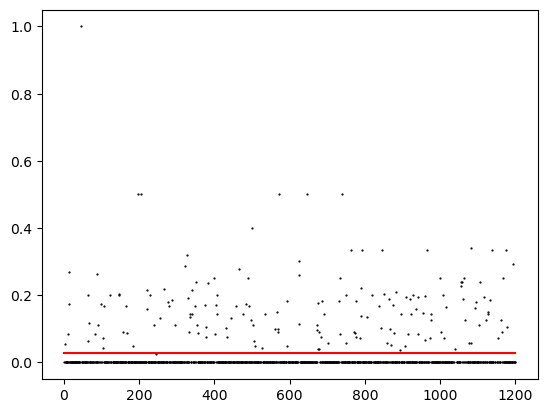

In [18]:
evaluate(modelrandom)

0.1462070792630667


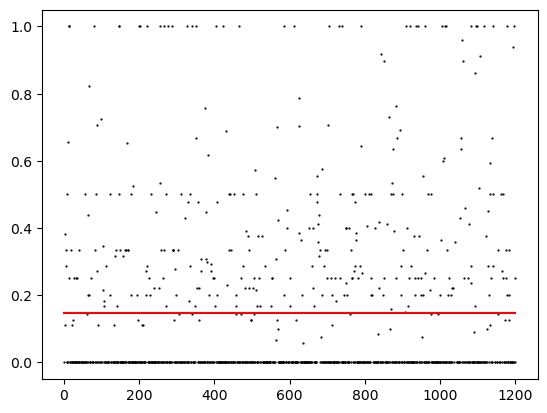

In [19]:
evaluate(model1)

0.21003954104804953


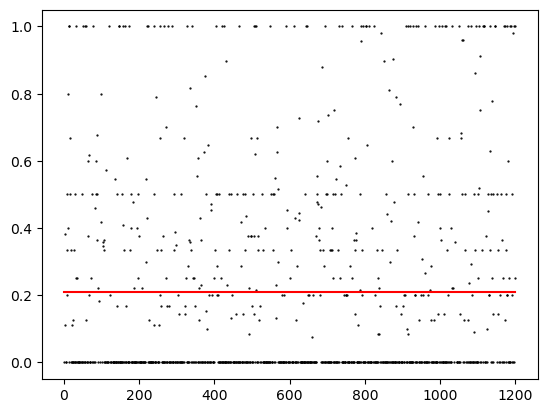

In [20]:
evaluate(model2)

0.4135671105682346


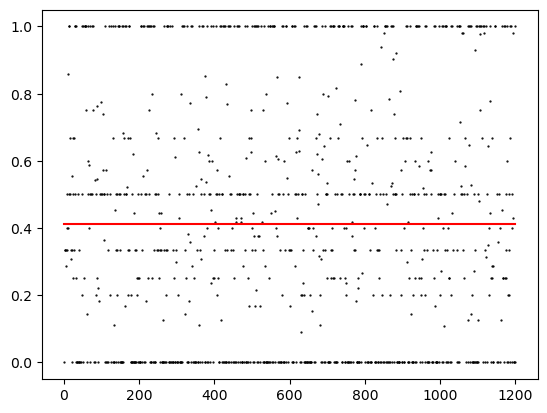

In [21]:
evaluate(model3)

0.5332839880823121


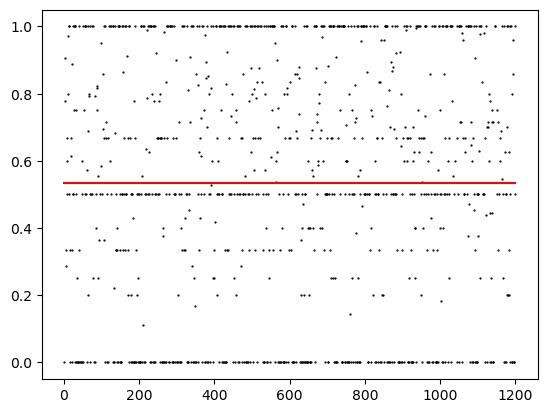

In [22]:
evaluate(model4)